In [806]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

In [804]:
!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz

--2015-11-06 17:22:26--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Server file no newer than local file ‘mnist.pkl.gz’ -- not retrieving.



In [805]:
train, val, test = pickle.load(gzip.open('mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val

In [11]:
X_train.shape

(50000, 784)

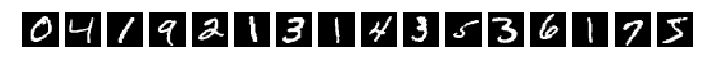

In [807]:
plt.figure(figsize=(12,3))
for i in range(16):
    plt.subplot(1, 16, i)
    plt.imshow(X_train[i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')

In [808]:
l_in = lasagne.layers.InputLayer((None, 784))
l_out = lasagne.layers.DenseLayer(
    l_in,
    num_units=10,
    nonlinearity=lasagne.nonlinearities.softmax)

In [812]:
X_sym = T.matrix()
y_sym = T.ivector()

In [813]:
output = lasagne.layers.get_output(l_out, X_sym)
pred = output.argmax(-1)

In [814]:
loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sym))

#l2_penalty = lasagne.regularization.regularize_layer_params(
#    l_out, lasagne.regularization.l2) * 1e-3
#loss += l2_penalty

acc = T.mean(T.eq(pred, y_sym))

In [815]:
params = lasagne.layers.get_all_params(l_out)

In [816]:
params

[W, b]

In [817]:
grad = T.grad(loss, params)
updates = lasagne.updates.sgd(grad, params, learning_rate=0.01)

In [793]:
f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates)
f_val = theano.function([X_sym, y_sym], [loss, acc])
f_predict = theano.function([X_sym], pred)

In [794]:
def batch_gen(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('int32')

In [795]:
train_batches = batch_gen(X_train, y_train, BATCH_SIZE)
val_batches = batch_gen(X_val, y_val, BATCH_SIZE)

In [796]:
X, y = next(train_batches)

0


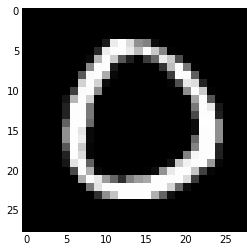

In [797]:
plt.imshow(X[0].reshape((28, 28)), cmap='gray', interpolation='nearest')
print(y[0])

In [798]:
BATCH_SIZE = 64
N_BATCHES = len(X_train) // BATCH_SIZE
N_VAL_BATCHES = len(X_val) // BATCH_SIZE

for epoch in range(15):
    train_loss = 0
    train_acc = 0
    for _ in range(N_BATCHES):
        X, y = next(train_batches)
        loss, acc = f_train(X, y)
        train_loss += loss
        train_acc += acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES

    val_loss = 0
    val_acc = 0
    for _ in range(N_VAL_BATCHES):
        X, y = next(val_batches)
        loss, acc = f_val(X, y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_VAL_BATCHES
    val_acc /= N_VAL_BATCHES
    
    print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
            epoch, train_loss, val_loss, val_loss/train_loss))
    print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))

Epoch 0, Train (val) loss 1.081 (0.638) ratio 0.590
Train (val) accuracy 0.751 (0.864)
Epoch 1, Train (val) loss 0.599 (0.497) ratio 0.831
Train (val) accuracy 0.858 (0.880)
Epoch 2, Train (val) loss 0.505 (0.444) ratio 0.879
Train (val) accuracy 0.873 (0.893)
Epoch 3, Train (val) loss 0.459 (0.402) ratio 0.874
Train (val) accuracy 0.881 (0.901)
Epoch 4, Train (val) loss 0.435 (0.378) ratio 0.868
Train (val) accuracy 0.885 (0.901)
Epoch 5, Train (val) loss 0.415 (0.366) ratio 0.883
Train (val) accuracy 0.889 (0.899)
Epoch 6, Train (val) loss 0.394 (0.356) ratio 0.904
Train (val) accuracy 0.893 (0.900)
Epoch 7, Train (val) loss 0.383 (0.359) ratio 0.936
Train (val) accuracy 0.895 (0.905)
Epoch 8, Train (val) loss 0.389 (0.340) ratio 0.875
Train (val) accuracy 0.892 (0.908)
Epoch 9, Train (val) loss 0.371 (0.329) ratio 0.886
Train (val) accuracy 0.899 (0.914)
Epoch 10, Train (val) loss 0.366 (0.335) ratio 0.914
Train (val) accuracy 0.898 (0.910)
Epoch 11, Train (val) loss 0.363 (0.326) r

In [799]:
weights = l_out.W.get_value()

In [800]:
weights.shape

(784, 10)

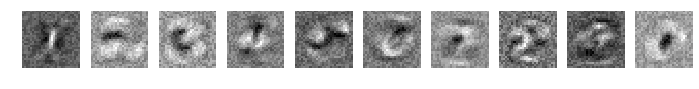

In [801]:
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1, 10, i)
    plt.imshow(weights[:,i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')

In [651]:
l_in = lasagne.layers.InputLayer((None, 784))
l_hid = lasagne.layers.DenseLayer(l_in,
                                  num_units=10,
                                  nonlinearity=lasagne.nonlinearities.rectify)
l_out = lasagne.layers.DenseLayer(l_hid,
                                  num_units=10,
                                  nonlinearity=lasagne.nonlinearities.softmax)

In [652]:
X_sym = T.matrix()
y_sym = T.ivector()

output = lasagne.layers.get_output(l_out, X_sym)
pred = output.argmax(-1)

loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sym))

acc = T.mean(T.eq(pred, y_sym))

params = lasagne.layers.get_all_params(l_out)
grad = T.grad(loss, params)
updates = lasagne.updates.adadelta(grad, params, learning_rate=0.001)

f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates)
f_val = theano.function([X_sym, y_sym], [loss, acc])
f_predict = theano.function([X_sym], pred)

In [653]:
BATCH_SIZE = 64
N_BATCHES = len(X_train) // BATCH_SIZE
N_VAL_BATCHES = len(X_val) // BATCH_SIZE

for epoch in range(15):
    train_loss = 0
    train_acc = 0
    for _ in range(N_BATCHES):
        X, y = next(train_batches)
        loss, acc = f_train(X, y)
        train_loss += loss
        train_acc += acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES

    val_loss = 0
    val_acc = 0
    for _ in range(N_VAL_BATCHES):
        X, y = next(val_batches)
        loss, acc = f_val(X, y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_VAL_BATCHES
    val_acc /= N_VAL_BATCHES
    
    print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
            epoch, train_loss, val_loss, val_loss/train_loss))
    print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))

Epoch 0, Train (val) loss 2.329 (2.288) ratio 0.983
Train (val) accuracy 0.113 (0.118)
Epoch 1, Train (val) loss 2.263 (2.235) ratio 0.988
Train (val) accuracy 0.118 (0.125)
Epoch 2, Train (val) loss 2.211 (2.180) ratio 0.986
Train (val) accuracy 0.127 (0.141)
Epoch 3, Train (val) loss 2.166 (2.132) ratio 0.984
Train (val) accuracy 0.146 (0.160)
Epoch 4, Train (val) loss 2.125 (2.088) ratio 0.983
Train (val) accuracy 0.164 (0.179)
Epoch 5, Train (val) loss 2.081 (2.058) ratio 0.989
Train (val) accuracy 0.181 (0.188)
Epoch 6, Train (val) loss 2.051 (2.013) ratio 0.982
Train (val) accuracy 0.191 (0.214)
Epoch 7, Train (val) loss 2.012 (1.978) ratio 0.983
Train (val) accuracy 0.211 (0.236)
Epoch 8, Train (val) loss 1.978 (1.943) ratio 0.982
Train (val) accuracy 0.233 (0.265)
Epoch 9, Train (val) loss 1.949 (1.911) ratio 0.981
Train (val) accuracy 0.261 (0.284)
Epoch 10, Train (val) loss 1.912 (1.885) ratio 0.986
Train (val) accuracy 0.291 (0.315)
Epoch 11, Train (val) loss 1.888 (1.848) r

In [656]:
l_in = lasagne.layers.InputLayer((None, 784))
l_hid = lasagne.layers.DenseLayer(l_in,
                                  num_units=500,
                                  nonlinearity=lasagne.nonlinearities.rectify)
l_dropout1 = lasagne.layers.DropoutLayer(l_hid, p=0.5)
l_hid2 = lasagne.layers.DenseLayer(l_dropout1,
                                  num_units=500,
                                  nonlinearity=lasagne.nonlinearities.rectify)
l_dropout2 = lasagne.layers.DropoutLayer(l_hid2, p=0.5)
l_out = lasagne.layers.DenseLayer(l_dropout2,
                                  num_units=10,
                                  nonlinearity=lasagne.nonlinearities.softmax)

X_sym = T.matrix()
y_sym = T.ivector()

output = lasagne.layers.get_output(l_out, X_sym)
pred = output.argmax(-1)

loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sym))

acc = T.mean(T.eq(pred, y_sym))

params = lasagne.layers.get_all_params(l_out)
grad = T.grad(loss, params)
updates = lasagne.updates.rmsprop(grad, params, learning_rate=0.001)

f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates)
f_val = theano.function([X_sym, y_sym], [loss, acc])
f_predict = theano.function([X_sym], pred)

BATCH_SIZE = 64
N_BATCHES = len(X_train) // BATCH_SIZE
N_VAL_BATCHES = len(X_val) // BATCH_SIZE

train_batches = batch_gen(X_train, y_train, BATCH_SIZE)
val_batches = batch_gen(X_val, y_val, BATCH_SIZE)

for epoch in range(50):
    train_loss = 0
    train_acc = 0
    for _ in range(N_BATCHES):
        X, y = next(train_batches)
        loss, acc = f_train(X, y)
        train_loss += loss
        train_acc += acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES

    val_loss = 0
    val_acc = 0
    for _ in range(N_VAL_BATCHES):
        X, y = next(val_batches)
        loss, acc = f_val(X, y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_VAL_BATCHES
    val_acc /= N_VAL_BATCHES
    
    print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
            epoch, train_loss, val_loss, val_loss/train_loss))
    print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))

Epoch 0, Train (val) loss 0.354 (0.205) ratio 0.579
Train (val) accuracy 0.890 (0.939)
Epoch 1, Train (val) loss 0.172 (0.169) ratio 0.984
Train (val) accuracy 0.948 (0.953)
Epoch 2, Train (val) loss 0.145 (0.153) ratio 1.054
Train (val) accuracy 0.957 (0.957)
Epoch 3, Train (val) loss 0.124 (0.140) ratio 1.123
Train (val) accuracy 0.964 (0.961)
Epoch 4, Train (val) loss 0.108 (0.131) ratio 1.216
Train (val) accuracy 0.969 (0.967)
Epoch 5, Train (val) loss 0.100 (0.141) ratio 1.415
Train (val) accuracy 0.973 (0.965)
Epoch 6, Train (val) loss 0.091 (0.143) ratio 1.573
Train (val) accuracy 0.974 (0.967)
Epoch 7, Train (val) loss 0.085 (0.126) ratio 1.486
Train (val) accuracy 0.975 (0.971)
Epoch 8, Train (val) loss 0.082 (0.118) ratio 1.432
Train (val) accuracy 0.977 (0.971)
Epoch 9, Train (val) loss 0.076 (0.138) ratio 1.811
Train (val) accuracy 0.979 (0.968)
Epoch 10, Train (val) loss 0.079 (0.123) ratio 1.553
Train (val) accuracy 0.978 (0.970)
Epoch 11, Train (val) loss 0.073 (0.134) r

KeyboardInterrupt: 

In [673]:
import sklearn.linear_model

In [674]:
clf = sklearn.linear_model.LogisticRegression()

In [675]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [676]:
clf.score(X_val, y_val)

0.92169999999999996